In [77]:
# General Imports
import os
import numpy as np
import pandas as pd
from time import strftime, localtime
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, cohen_kappa_score, hamming_loss

# [TODO] edit the path to the tfslim directoy "https://github.com/tensorflow/models/tree/master/research/slim"
SLIM_PATH = '/srv/workspace/research/mlml/models/research/slim'
os.chdir(SLIM_PATH)

# Deep Learning
import tensorflow as tf
from nets import inception
from datasets import dataset_utils
from tensorflow.contrib import slim


plt.rcParams.update({'font.size': 22})

# [TODO] edit the paths to match the machine's directories 
SOURCE_PATH = "/srv/workspace/research/mlml/mlml_weightedLoss/"
# path to the formatted dataset
IMAGES_PATH = "/srv/workspace/research/mlml/datasets/mscoco/train_formatted_normalized_npz/"
TEST_IMAGES_PATH = IMAGES_PATH
# path to the output direcorty
OUTPUT_PATH ="/srv/workspace/research/mlml/experiments_results_balanced/"
# path to the pretrained model (if not downloaded already, call the download_pretrained_model function below)
PRETRAINED_MODEL_DIR = '/srv/workspace/research/mlml/pretrained_models/'

INPUT_SHAPE = (224, 224, 3)
INPUT_IMAGE_MEAN = [0.485, 0.456, 0.406]
INPUT_IMAGE_STD = [0.229, 0.224, 0.225]

labels_set = pd.read_csv('/srv/workspace/research/mlml/mlml_weightedLoss/labels_balanced_4labels/missing_labels0.0/train1_0.0.csv')
labels_set.drop("Unnamed: 0", axis = 1, inplace = True)

LABELS_LIST = labels_set.columns
NUM_CLASSES = len(LABELS_LIST)

# Training paramaeters
BATCH_SIZE = 32
TRAINING_STEPS = int(len(labels_set)/BATCH_SIZE)
NUM_EPOCHS = 20
# compute the weights to balance between the ratio of positive and negative samples per label (not the confidence-based weights) 
Pos_balance_weights = np.round((1 / (np.sum(labels_set.values, axis = 0)/ len(labels_set))/2)).astype(np.float32)
Pos_balance_weights = np.clip(Pos_balance_weights,1,10.0)

In [78]:
# Define helper functions

def download_pretrained_model():
    url = "http://download.tensorflow.org/models/inception_resnet_v2_2016_08_30.tar.gz"
    if not tf.gfile.Exists(PRETRAINED_MODEL_DIR):
        tf.gfile.MakeDirs(PRETRAINED_MODEL_DIR)
    dataset_utils.download_and_uncompress_tarball(url, PRETRAINED_MODEL_DIR)

# functions for defining the model
def get_weights(shape):
    w = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    return w

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    b = tf.Variable(initial)
    return b

def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = get_weights([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b

def dataset_from_csv(csv_path, **kwargs):
    """
        Load dataset from a csv file.
        kwargs are forwarded to the pandas.read_csv function.
    """
    df = pd.read_csv(csv_path, **kwargs)

    dataset = (
        tf.data.Dataset.from_tensor_slices(
            {
                key:df[key].values
                for key in df
            }
        )
    )
    return dataset

def set_tensor_shape(tensor, tensor_shape):
        """
            set shape for a tensor (not in place, as opposed to tf.set_shape)
        """
        tensor.set_shape(tensor_shape)
        return tensor

def mscoco_labels_idx_to_names(labels,labelnames = LABELS_LIST):
    return labelnames[np.where(labels == 1)]

# Dataset piplines [load images]
def load_image_npz(*args):
    """
        loads image with error tracking.
        args : image ID, path to dataset
        return:
            Features: numpy ndarray, computed features (if no error occured, otherwise: 0)
            Error: boolean, False if no error, True if an error was raised during features computation.
    """
    path = IMAGES_PATH
    image_id, dummy_path = args
    try:
        image = np.load(os.path.join(path, str(image_id) + '.npz'))['image']
        return image, False
    except Exception as err:
        print("\n Error while computing features for " + str(image_id) + '\n')
        return np.float32(0.0), True

def load_imge_tf(sample, identifier_key="Unnamed: 0",
                 path="/srv/workspace/research/mlml/datasets/mscoco/train_formatted_npz/", device="/cpu:0",
                 features_key="features"):
    """
        wrap load_images into a tensorflow function.
    """
    with tf.device(device):
        input_args = [sample[identifier_key], tf.constant(path)]
        res = tf.py_func(load_image_npz,
                         input_args,
                         (tf.float32, tf.bool),
                         stateful=False),
        image, error = res[0]
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        res = dict(list(sample.items()) + [(features_key, image), ("error", error)])
        return res

    
# Dataset pipelines [load weights]
def get_weights_py(image_id):
    weights_negative = global_weights_negative[global_weights_negative.iloc[:,0] == image_id]
    samples_weights_negative = weights_negative.iloc[:, 1:].values.flatten()
    samples_weights_negative = samples_weights_negative.astype(np.float32)
    return samples_weights_negative

def tf_get_weights_py(sample,device = "/cpu:0"):
    with tf.device(device):
        input_args = [sample["Unnamed: 0"]]
        negative_weights = tf.py_func(get_weights_py,
            input_args,
            [tf.float32],
            stateful=False)
        res = dict(list(sample.items()) + [("negative_weights", negative_weights)])
        return res
    

# Dataset pipelines [load labels]
def get_labels_py(image_id):
    labels = global_labels[global_labels.iloc[:,0] == image_id]
    labels = labels.iloc[:, 1:].values.flatten()
    labels = labels.astype(np.float32)
    return labels


def tf_get_labels_py(sample, device="/cpu:0"):
    with tf.device(device):
        input_args = [sample["Unnamed: 0"]]
        labels = tf.py_func(get_labels_py,
                            input_args,
                            [tf.float32],
                            stateful=False)
        res = dict(list(sample.items()) + [("binary_label", labels)])
        return res


def get_dataset(input_csv, input_shape=INPUT_SHAPE, batch_size=BATCH_SIZE, shuffle=True,
                infinite_generator=True, random_crop=False,
                num_parallel_calls=32):
    # build dataset from csv file
    dataset = dataset_from_csv(input_csv)
    # Shuffle data
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100, seed=0, reshuffle_each_iteration=True)

    # load image
    dataset = dataset.map(lambda sample: load_imge_tf(sample), num_parallel_calls=1)

    # filter out errors
    dataset = dataset.filter(lambda sample: tf.logical_not(sample["error"]))

    # set features shape
    dataset = dataset.map(lambda sample: dict(sample,
                                              features=set_tensor_shape(sample["features"], input_shape)))

    dataset = dataset.map(lambda sample: tf_get_labels_py(sample), num_parallel_calls=1)

    # set output shape
    dataset = dataset.map(lambda sample: dict(sample, binary_label=set_tensor_shape(
        sample["binary_label"], (NUM_CLASSES))))
    
    # load weights
    dataset = dataset.map(lambda sample: tf_get_weights_py(sample), num_parallel_calls=1)
    
    dataset = dataset.map(lambda sample: dict(sample, negative_weights=set_tensor_shape(
    sample["negative_weights"], (NUM_CLASSES))))
    
    if infinite_generator:
        # Repeat indefinitly
        dataset = dataset.repeat(count=-1)

    # Make batch
    dataset = dataset.batch(batch_size)

    # Select only features and annotation
    dataset = dataset.map(lambda sample: (sample["features"], sample["binary_label"],
                                          sample["negative_weights"]))

    return dataset

In [ ]:
 def create_analysis_report(model_output, groundtruth, output_path, LABELS_LIST, validation_output=None,
                           validation_groundtruth=None):
    """
    Create a report of all the different evaluation metrics, including optimizing the threshold with the validation set
    if it is passed in the parameters
    """
    # Round the probabilities at 0.5
    model_output_rounded = np.round(model_output)
    model_output_rounded = np.clip(model_output_rounded, 0, 1)
    # Create a dataframe where we keep all the evaluations, starting by prediction accuracy
    accuracies_perclass = sum(model_output_rounded == groundtruth) / len(groundtruth)
    results_df = pd.DataFrame(columns=LABELS_LIST)
    results_df.index.astype(str, copy=False)
    percentage_of_positives_perclass = sum(groundtruth) / len(groundtruth)
    results_df.loc[0] = percentage_of_positives_perclass
    results_df.loc[1] = accuracies_perclass
    results_df.index = ['Ratio of positive samples', 'Model accuracy']

    # plot the accuracies per class
    results_df.T.plot.bar(figsize=(22, 12), fontsize=18)
    plt.title('Model accuracy vs the ratio of positive samples per class')
    plt.xticks(rotation=45)
    plt.savefig(os.path.join(output_path, "accuracies_vs_positiveRate.pdf"), format="pdf")
    plt.savefig(os.path.join(output_path, "accuracies_vs_positiveRate.png"))

    # Getting the true positive rate perclass
    true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(groundtruth)
    results_df.loc[2] = true_positives_ratio_perclass
    # Get true negative ratio
    true_negative_ratio_perclass = sum((model_output_rounded == groundtruth)
                                       * (groundtruth == 0)) / (len(groundtruth) - sum(groundtruth))
    results_df.loc[3] = true_negative_ratio_perclass
    # compute additional metrics (AUC,f1,recall,precision)
    auc_roc_per_label = roc_auc_score(groundtruth, model_output, average=None)
    precision_perlabel = precision_score(groundtruth, model_output_rounded, average=None)
    recall_perlabel = recall_score(groundtruth, model_output_rounded, average=None)
    f1_perlabel = f1_score(groundtruth, model_output_rounded, average=None)
    kappa_perlabel = [cohen_kappa_score(groundtruth[:, x], model_output_rounded[:, x]) for x in range(len(LABELS_LIST))]
    results_df = results_df.append(
        pd.DataFrame([auc_roc_per_label,recall_perlabel, precision_perlabel, f1_perlabel, kappa_perlabel], columns=LABELS_LIST))
    results_df.index = ['Ratio of positive samples', 'Model accuracy', 'True positives ratio',
                        'True negatives ratio', "AUC", "Recall", "Precision", "f1-score", "Kappa score"]


    # Adjusting threshold based on validation set
    if (validation_groundtruth is not None and validation_output is not None):
        np.savetxt(os.path.join(output_path, 'validation_predictions.out'), validation_output, delimiter=',')
        np.savetxt(os.path.join(output_path, 'valid_ground_truth_classes.txt'), validation_groundtruth, delimiter=',')
        thresholds = np.arange(0, 1, 0.01)
        f1_array = np.zeros((len(LABELS_LIST), len(thresholds)))
        for idx, label in enumerate(LABELS_LIST):
            f1_array[idx, :] = [
                f1_score(validation_groundtruth[:, idx], np.clip(np.round(validation_output[:, idx] - threshold + 0.5), 0, 1))
                for threshold in thresholds]
        threshold_arg = np.argmax(f1_array, axis=1)
        threshold_per_class = thresholds[threshold_arg]

        # plot the f1 score across thresholds
        plt.figure(figsize=(20, 20))
        for idx, x in enumerate(LABELS_LIST):
            plt.plot(thresholds, f1_array[idx, :], linewidth=5)
        plt.legend(LABELS_LIST, loc='best')
        plt.title("F1 Score vs different prediction threshold values for each class")
        plt.savefig(os.path.join(output_path, "f1_score_vs_thresholds.pdf"), format="pdf")
        plt.savefig(os.path.join(output_path, "f1_score_vs_thresholds.png"))

        # Applying thresholds optimized per class
        model_output_rounded = np.zeros_like(model_output)
        for idx, label in enumerate(LABELS_LIST):
            model_output_rounded[:, idx] = np.clip(np.round(model_output[:, idx] - threshold_per_class[idx] + 0.5), 0, 1)

        accuracies_perclass = sum(model_output_rounded == groundtruth) / len(groundtruth)
        # Getting the true positive rate perclass
        true_positives_ratio_perclass = sum((model_output_rounded == groundtruth) * (groundtruth == 1)) / sum(
            groundtruth)
        # Get true negative ratio
        true_negative_ratio_perclass = sum((model_output_rounded == groundtruth)
                                           * (groundtruth == 0)) / (len(groundtruth) - sum(groundtruth))
        results_df = results_df.append(
            pd.DataFrame([accuracies_perclass, true_positives_ratio_perclass,
                          true_negative_ratio_perclass], columns=LABELS_LIST))
        # compute additional metrics (AUC,f1,recall,precision)
        auc_roc_per_label = roc_auc_score(groundtruth, model_output, average=None)
        precision_perlabel = precision_score(groundtruth, model_output_rounded, average=None)
        recall_perlabel = recall_score(groundtruth, model_output_rounded, average=None)
        f1_perlabel = f1_score(groundtruth, model_output_rounded, average=None)
        kappa_perlabel = [cohen_kappa_score(groundtruth[:, x], model_output_rounded[:, x]) for x in
                          range(len(LABELS_LIST))]
        results_df = results_df.append(
            pd.DataFrame([auc_roc_per_label,recall_perlabel, precision_perlabel, f1_perlabel,kappa_perlabel],
                         columns=LABELS_LIST))
        results_df.index = ['Ratio of positive samples', 'Model accuracy', 'True positives ratio',
                            'True negatives ratio', "AUC", "Precision", "Recall", "f1-score",  "Kappa score",
                            'Optimized model accuracy', 'Optimized true positives ratio',
                            'Optimized true negatives ratio', "Optimized AUC",
                            "Optimized precision", "Optimized recall", "Optimized f1-score",  "Optimized Kappa score"]

    results_df['average'] = results_df.mean(numeric_only=True, axis=1)
    results_df.T.to_csv(os.path.join(output_path, "results_report.csv"), float_format="%.2f")
    return results_df


def evaluate_model(test_pred_prob, test_classes, saving_path, evaluation_file_path):
    """
    Evaluates a given model using accuracy, area under curve and hamming loss
    :param model: model to be evaluated
    :param spectrograms: the test set spectrograms as an np.array
    :param test_classes: the ground truth labels
    :return: accuracy, auc_roc, hamming_error
    """
    test_pred = np.round(test_pred_prob)
    # Accuracy
    accuracy = 100 * accuracy_score(test_classes, test_pred)
    print("Exact match accuracy is: " + str(accuracy) + "%")
    # Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    auc_roc = roc_auc_score(test_classes, test_pred_prob)
    print("Macro Area Under the Curve (AUC) is: " + str(auc_roc))
    auc_roc_micro = roc_auc_score(test_classes, test_pred_prob, average="micro")
    print("Micro Area Under the Curve (AUC) is: " + str(auc_roc_micro))
    auc_roc_weighted = roc_auc_score(test_classes, test_pred_prob, average="weighted")
    print("Weighted Area Under the Curve (AUC) is: " + str(auc_roc_weighted))
    # Hamming loss is the fraction of labels that are incorrectly predicted.
    hamming_error = hamming_loss(test_classes, test_pred)
    print("Hamming Loss (ratio of incorrect tags) is: " + str(hamming_error))
    with open(evaluation_file_path, "w") as f:
        f.write("Exact match accuracy is: " + str(accuracy) + "%\n" + "Area Under the Curve (AUC) is: " + str(auc_roc)
                + "\nMicro AUC is:" + str(auc_roc_micro) + "\nWeighted AUC is:" + str(auc_roc_weighted)
                + "\nHamming Loss (ratio of incorrect tags) is: " + str(hamming_error))
    print("saving prediction to disk")
    np.savetxt(os.path.join(saving_path, 'predictions.out'), test_pred_prob, delimiter=',')
    np.savetxt(os.path.join(saving_path, 'test_ground_truth_classes.txt'), test_classes, delimiter=',')
    return accuracy, auc_roc, hamming_error

## fine-tune pretrained model on the dataset

In [ ]:
for split in np.arange(1,5):
    for ratio in np.arange(0,1,0.25): 
        tf.reset_default_graph()
        EXPERIMENTNAME = "PosLimited_original_CE_balanced_ratio" + str(round(ratio, 1)) + "split_" + str(split)
        print("Current Experiment: " + EXPERIMENTNAME + "\n\n\n")
        global_labels = pd.read_csv('/srv/workspace/research/mlml/mlml_weightedLoss/labels_balanced_4labels/missing_labels'+
                                    str(round(ratio, 1))+'/train' + str(split) +"_" + str(round(ratio, 1)) + '.csv')
        # Loading datasets
        training_dataset = get_dataset('/srv/workspace/research/mlml/mlml_weightedLoss/labels_balanced_4labels/missing_labels'+
                                    str(round(ratio, 1))+'/train' + str(split) +"_" + str(round(ratio, 1)) + '.csv')
        
        global_weights_negative = pd.read_csv('/srv/workspace/research/mlml/mlml_weightedLoss/labels_balanced_4labels/missing_labels'+
                            str(round(ratio, 1))+'/negative_weights' + str(split) +"_"  + str(round(ratio, 1)) + '.csv')

        with tf.Graph().as_default():
            # Setting up training generator
            training_iterator = training_dataset.make_one_shot_iterator()
            training_next_element = training_iterator.get_next()

            # Setting up variables
            input_labels = tf.placeholder(tf.float32, [None, NUM_CLASSES], name="true_labels")
            input_images = tf.placeholder(tf.float32, [None, 224, 224, 3], name="input")
            train_phase = tf.placeholder(tf.bool, name="is_training")

            # Create the model, use the default arg scope to configure the batch norm parameters.
            with slim.arg_scope(inception.inception_resnet_v2_arg_scope()):
                ignored_logits, end_points = inception.inception_resnet_v2(input_images, num_classes=NUM_CLASSES, 
                                                           is_training=train_phase)
            
            featured_extracted = end_points['Conv2d_7b_1x1']
            
            with tf.name_scope('trainable/Fully_connected_1'):
                flattened = tf.reshape(featured_extracted, [-1, 5*5* 1536])
                fully1 = tf.nn.sigmoid(full_layer(flattened, 2048))
                
            with tf.name_scope('trainable/Fully_connected_2'):
                fully2 = tf.nn.sigmoid(full_layer(fully1, 1024))

            with tf.name_scope('trainable/Fully_connected_3'):
                fully3 = tf.nn.sigmoid(full_layer(fully2, 256)) 
                
            with tf.name_scope('trainable/Fully_connected_4'):
                #dropped = tf.nn.dropout(fully1, keep_prob=current_keep_prob)
                output_logits = full_layer(fully3, NUM_CLASSES)

            trainable_layers = [var for var in tf.global_variables() if ("trainable" in var.op.name)]
            # Defining loss and metrics
            # Define loss and training optimizer
            positive_imbalance_weights = tf.constant(Pos_balance_weights)
            loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(input_labels,output_logits,
                                                                           positive_imbalance_weights))
            probabilities = tf.nn.sigmoid(output_logits)

            global_step = tf.Variable(0, trainable=False)
            learning_rate = tf.train.exponential_decay(learning_rate=0.1, global_step=global_step, decay_steps=1000,
                                                      decay_rate=0.95,staircase=True)
            train_step = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss,var_list=trainable_layers)

            # define accuracy
            correct_prediction = tf.equal(tf.round(probabilities), input_labels)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            # Adding tensorboard summaries
            tf.summary.scalar('Original_cross_entropy', loss)
            tf.summary.scalar('Accuracy', accuracy)
            # Merge all the summaries
            merged = tf.summary.merge_all()

            # restoring pretrained model weights
            checkpoint_exclude_scopes = ["InceptionResnetV2/Logits", "InceptionResnetV2/AuxLogits"]
            exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]
            variables_to_restore = []
            for var in slim.get_model_variables():
                for exclusion in exclusions:
                    if var.op.name.startswith(exclusion):
                        break
                else:
                    variables_to_restore.append(var)
            init_fn = slim.assign_from_checkpoint_fn(
                os.path.join(PRETRAINED_MODEL_DIR, 'inception_resnet_v2_2016_08_30.ckpt'),
                variables_to_restore)

            # Setting up saving directory
            experiment_name = strftime("%d-%m_%H-%M", localtime())
            exp_dir = os.path.join(OUTPUT_PATH, EXPERIMENTNAME, experiment_name)

            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()

            with tf.Session() as sess:
                # Write summaries to LOG_DIR -- used by TensorBoard
                train_writer = tf.summary.FileWriter(exp_dir + '/tensorboard/train', graph=tf.get_default_graph())
                test_writer = tf.summary.FileWriter(exp_dir + '/tensorboard/test', graph=tf.get_default_graph())
                print("Execute the following in a terminal:\n" + "tensorboard --logdir=" + exp_dir)
                sess.run(tf.global_variables_initializer())
                init_fn(sess)
                for epoch in range(NUM_EPOCHS):
                    batch_loss, batch_accuracy = np.zeros([TRAINING_STEPS, 1]), np.zeros([TRAINING_STEPS, 1])
                    for batch_counter in range(TRAINING_STEPS):
                        batch = sess.run(training_next_element)
                        batch_images = batch[0]
                        batch_labels = np.squeeze(batch[1])
                        summary, batch_loss[batch_counter], batch_accuracy[batch_counter], _ \
                        = sess.run([merged, loss, accuracy, train_step],
                                   feed_dict={input_images:batch_images,input_labels:batch_labels,train_phase:True})
                    print("Epoch #{}".format(epoch+1), "Loss: {:.4f}".format(np.mean(batch_loss)),
                          "accuracy: {:.4f}".format(np.mean(batch_accuracy)))
                    # Add to summaries
                    train_writer.add_summary(summary, epoch)
                    
                os.makedirs(os.path.join(PRETRAINED_MODEL_DIR,EXPERIMENTNAME,experiment_name))
                save_path = saver.save(sess, os.path.join(PRETRAINED_MODEL_DIR,EXPERIMENTNAME, 
                                              experiment_name, "last_epoch.ckpt"))
                
                # Testing the model
                test_split = '/srv/workspace/research/mlml/mlml_weightedLoss/labels_balanced_4labels/missing_labels'+ \
                                    str(round(ratio, 1))+'/test' + str(split) + "_" + str(round(ratio, 1)) + '.csv'
                global_labels = pd.read_csv(test_split)
                test_dataset = get_dataset(test_split)
                test_classes = np.zeros_like(global_labels.iloc[:,1:].values, dtype=float)

                TEST_NUM_STEPS = int(np.floor((len(global_labels)/BATCH_SIZE)))
                test_pred_prob = np.zeros_like(test_classes, dtype=float)
                test_iterator = test_dataset.make_one_shot_iterator()
                test_next_element = test_iterator.get_next()
                
                for test_batch_counter in range(TEST_NUM_STEPS):
                    start_idx = (test_batch_counter * BATCH_SIZE)
                    end_idx = (test_batch_counter * BATCH_SIZE) + BATCH_SIZE
                    test_batch = sess.run(test_next_element)
                    test_batch_images = test_batch[0]
                    test_batch_labels = np.squeeze(test_batch[1])
                    test_classes[start_idx:end_idx,:] = test_batch_labels
                    test_pred_prob[start_idx:end_idx,:] = sess.run(probabilities,
                                                             feed_dict={input_images:test_batch_images,train_phase:False})

                accuracy_out, auc_roc, hamming_error = evaluate_model(test_pred_prob, test_classes,
                                                                  saving_path=exp_dir,
                                                                  evaluation_file_path= \
                                                                  os.path.join(exp_dir,"evaluation_results.txt"))           
                results = create_analysis_report(test_pred_prob, test_classes, exp_dir, LABELS_LIST)

Current Experiment: PosLimited_original_CE_balanced_ratio0.0split_1



Execute the following in a terminal:
tensorboard --logdir=/srv/workspace/research/mlml/experiments_results_balanced/PosLimited_original_CE_balanced_ratio0.0split_1/19-12_11-24
INFO:tensorflow:Restoring parameters from /srv/workspace/research/mlml/pretrained_models/inception_resnet_v2_2016_08_30.ckpt
Epoch #1 Loss: 0.7099 accuracy: 0.8937
Epoch #2 Loss: 0.6609 accuracy: 0.9385
Epoch #3 Loss: 0.6464 accuracy: 0.9391
Epoch #4 Loss: 0.6250 accuracy: 0.9401
Epoch #5 Loss: 0.5973 accuracy: 0.9382
Epoch #6 Loss: 0.5676 accuracy: 0.9309
Epoch #7 Loss: 0.5424 accuracy: 0.9214
Epoch #8 Loss: 0.5239 accuracy: 0.9139
Epoch #9 Loss: 0.5108 accuracy: 0.9094
Epoch #10 Loss: 0.5005 accuracy: 0.9071
Epoch #11 Loss: 0.4918 accuracy: 0.9056
Epoch #12 Loss: 0.4845 accuracy: 0.9052
Epoch #13 Loss: 0.4782 accuracy: 0.9050
Epoch #14 Loss: 0.4724 accuracy: 0.9051
Epoch #15 Loss: 0.4671 accuracy: 0.9052
Epoch #16 Loss: 0.4626 accuracy: 0.90

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Current Experiment: PosLimited_original_CE_balanced_ratio0.2split_1



Execute the following in a terminal:
tensorboard --logdir=/srv/workspace/research/mlml/experiments_results_balanced/PosLimited_original_CE_balanced_ratio0.2split_1/19-12_12-17
INFO:tensorflow:Restoring parameters from /srv/workspace/research/mlml/pretrained_models/inception_resnet_v2_2016_08_30.ckpt
Epoch #1 Loss: 0.6159 accuracy: 0.9074
Epoch #2 Loss: 0.5633 accuracy: 0.9517
Epoch #3 Loss: 0.5555 accuracy: 0.9520
Epoch #4 Loss: 0.5452 accuracy: 0.9523
Epoch #5 Loss: 0.5312 accuracy: 0.9528
Epoch #6 Loss: 0.5141 accuracy: 0.9530
Epoch #7 Loss: 0.4952 accuracy: 0.9515
Epoch #8 Loss: 0.4781 accuracy: 0.9471
Epoch #9 Loss: 0.4633 accuracy: 0.9416
Epoch #10 Loss: 0.4526 accuracy: 0.9365
Epoch #11 Loss: 0.4434 accuracy: 0.9326
Epoch #12 Loss: 0.4361 accuracy: 0.9300
Epoch #13 Loss: 0.4305 accuracy: 0.9283
Epoch #14 Loss: 0.4251 accuracy: 0.9276
Epoch #15 Loss: 0.4203 accuracy: 0.9268
Epoch #16 Loss: 0.4167 accuracy: 0.92

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Current Experiment: PosLimited_original_CE_balanced_ratio0.5split_1



Execute the following in a terminal:
tensorboard --logdir=/srv/workspace/research/mlml/experiments_results_balanced/PosLimited_original_CE_balanced_ratio0.5split_1/19-12_13-28
INFO:tensorflow:Restoring parameters from /srv/workspace/research/mlml/pretrained_models/inception_resnet_v2_2016_08_30.ckpt
Epoch #1 Loss: 0.5052 accuracy: 0.9299
Epoch #2 Loss: 0.4521 accuracy: 0.9658
Epoch #3 Loss: 0.4487 accuracy: 0.9658
Epoch #4 Loss: 0.4445 accuracy: 0.9658
Epoch #5 Loss: 0.4385 accuracy: 0.9659
Epoch #6 Loss: 0.4312 accuracy: 0.9658
Epoch #7 Loss: 0.4218 accuracy: 0.9658
Epoch #8 Loss: 0.4112 accuracy: 0.9658
Epoch #9 Loss: 0.3999 accuracy: 0.9654
Epoch #10 Loss: 0.3892 accuracy: 0.9644
Epoch #11 Loss: 0.3795 accuracy: 0.9626
Epoch #12 Loss: 0.3718 accuracy: 0.9604
Epoch #13 Loss: 0.3659 accuracy: 0.9580
Epoch #14 Loss: 0.3608 accuracy: 0.9562
Epoch #15 Loss: 0.3565 accuracy: 0.9547
Epoch #16 Loss: 0.3528 accuracy: 0.95

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Current Experiment: PosLimited_original_CE_balanced_ratio0.8split_1



Execute the following in a terminal:
tensorboard --logdir=/srv/workspace/research/mlml/experiments_results_balanced/PosLimited_original_CE_balanced_ratio0.8split_1/19-12_14-39
INFO:tensorflow:Restoring parameters from /srv/workspace/research/mlml/pretrained_models/inception_resnet_v2_2016_08_30.ckpt
Epoch #1 Loss: 0.3593 accuracy: 0.9415
Epoch #2 Loss: 0.2809 accuracy: 0.9832
Epoch #3 Loss: 0.2796 accuracy: 0.9833
Epoch #4 Loss: 0.2788 accuracy: 0.9833
Epoch #5 Loss: 0.2779 accuracy: 0.9833
Epoch #6 Loss: 0.2771 accuracy: 0.9833
Epoch #7 Loss: 0.2757 accuracy: 0.9833
Epoch #8 Loss: 0.2744 accuracy: 0.9832
Epoch #9 Loss: 0.2727 accuracy: 0.9833
Epoch #10 Loss: 0.2708 accuracy: 0.9832
Epoch #11 Loss: 0.2684 accuracy: 0.9833
Epoch #12 Loss: 0.2658 accuracy: 0.9833
Epoch #13 Loss: 0.2631 accuracy: 0.9832
Epoch #14 Loss: 0.2599 accuracy: 0.9833
Epoch #15 Loss: 0.2566 accuracy: 0.9832
Epoch #16 Loss: 0.2531 accuracy: 0.98

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Current Experiment: PosLimited_original_CE_balanced_ratio0.0split_2



Execute the following in a terminal:
tensorboard --logdir=/srv/workspace/research/mlml/experiments_results_balanced/PosLimited_original_CE_balanced_ratio0.0split_2/19-12_15-52
INFO:tensorflow:Restoring parameters from /srv/workspace/research/mlml/pretrained_models/inception_resnet_v2_2016_08_30.ckpt
Epoch #1 Loss: 0.7081 accuracy: 0.9021
Epoch #2 Loss: 0.6619 accuracy: 0.9384
Epoch #3 Loss: 0.6463 accuracy: 0.9388
Epoch #4 Loss: 0.6249 accuracy: 0.9394
Epoch #5 Loss: 0.5970 accuracy: 0.9367
Epoch #6 Loss: 0.5668 accuracy: 0.9284
Epoch #7 Loss: 0.5408 accuracy: 0.9186
Epoch #8 Loss: 0.5224 accuracy: 0.9114
Epoch #9 Loss: 0.5089 accuracy: 0.9071
Epoch #10 Loss: 0.4991 accuracy: 0.9051
Epoch #11 Loss: 0.4900 accuracy: 0.9040
Epoch #12 Loss: 0.4826 accuracy: 0.9039
Epoch #13 Loss: 0.4766 accuracy: 0.9038
Epoch #14 Loss: 0.4706 accuracy: 0.9038
Epoch #15 Loss: 0.4661 accuracy: 0.9039
Epoch #16 Loss: 0.4607 accuracy: 0.90

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (

Current Experiment: PosLimited_original_CE_balanced_ratio0.2split_2



Execute the following in a terminal:
tensorboard --logdir=/srv/workspace/research/mlml/experiments_results_balanced/PosLimited_original_CE_balanced_ratio0.2split_2/19-12_17-11
INFO:tensorflow:Restoring parameters from /srv/workspace/research/mlml/pretrained_models/inception_resnet_v2_2016_08_30.ckpt
Epoch #1 Loss: 0.6071 accuracy: 0.9170
Epoch #2 Loss: 0.5642 accuracy: 0.9515
Epoch #3 Loss: 0.5548 accuracy: 0.9518
Epoch #4 Loss: 0.5421 accuracy: 0.9522
Epoch #5 Loss: 0.5255 accuracy: 0.9527
Epoch #6 Loss: 0.5057 accuracy: 0.9524
Epoch #7 Loss: 0.4857 accuracy: 0.9492
Epoch #8 Loss: 0.4691 accuracy: 0.9436
Epoch #9 Loss: 0.4560 accuracy: 0.9381
Epoch #10 Loss: 0.4461 accuracy: 0.9339
Epoch #11 Loss: 0.4376 accuracy: 0.9309
Epoch #12 Loss: 0.4312 accuracy: 0.9289
Epoch #13 Loss: 0.4255 accuracy: 0.9277
Epoch #14 Loss: 0.4206 accuracy: 0.9268
Epoch #15 Loss: 0.4166 accuracy: 0.9262
Epoch #16 Loss: 0.4121 accuracy: 0.92

In [61]:
split= 1 
ratio = 0.75 
global_labels = pd.read_csv('/srv/workspace/research/mlml/mlml_weightedLoss/labels_balanced_4labels/missing_labels'+
                            str(round(ratio, 1))+'/train' + str(split) +"_" + str(round(ratio, 1)) + '.csv')
# Loading datasets
training_dataset = get_dataset('/srv/workspace/research/mlml/mlml_weightedLoss/labels_balanced_4labels/missing_labels'+
                            str(round(ratio, 1))+'/train' + str(split) +"_" + str(round(ratio, 1)) + '.csv')

global_weights_negative = pd.read_csv('/srv/workspace/research/mlml/mlml_weightedLoss/labels_balanced_4labels/missing_labels'+
                            str(round(ratio, 1))+'/negative_weights' + str(split) +"_"  + str(round(ratio, 1)) + '.csv')

training_iterator = training_dataset.make_one_shot_iterator()
training_next_element = training_iterator.get_next()
with tf.Session() as sess:
    batch = sess.run(training_next_element)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


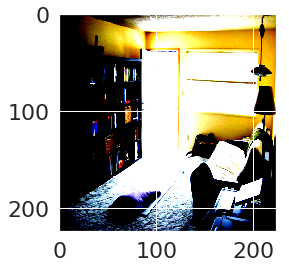

In [73]:
plt.imshow(batch[0][0])

In [72]:
mscoco_labels_idx_to_names(batch[1][0][0])

Index(['chair', 'book'], dtype='object')

In [71]:
mscoco_labels_idx_to_names(1- batch[2][0][0])

Index(['backpack', 'couch', 'potted plant', 'laptop', 'mouse', 'keyboard'], dtype='object')